## 範例
參考 `train.py` 實現的訓練模型程式碼範例


In [1]:
%tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.0


In [0]:
#pip install keras==2.2.4 # 需要安裝 keras 2.2.4 的版本

     |████████████████████████████████| 317kB 44.8MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [2]:
from google.colab import drive 
drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# 下載基於 keras 的 yolov3 程式碼
%cd 'gdrive/My Drive'
# !git clone https://github.com/qqwweee/keras-yolo3 # 如果之前已經下載過就可以註解掉
%cd my-keras-yolo3

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive
/content/gdrive/My Drive/my-keras-yolo3


In [3]:
import os
if not os.path.exists("model_data/yolo.h5"):
  # 下載 yolov3 的網路權重，並且把權重轉換為 keras 能夠讀取的格式
  #print("Model doesn't exist, downloading...")
  #os.system("wget https://pjreddie.com/media/files/yolov3.weights")
  print("Converting yolov3.weights to yolo.h5...")
  os.system("python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5")
else:
  print("Model exist")

Model exist


In [4]:
# 將 train.py 所需要的套件載入
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

Using TensorFlow backend.


把 YOLO weights 轉換為能夠提供給 keras 作為訓練新模型的初始權重，注意這部分多了一個 -w 的參數，可以參考 https://github.com/qqwweee/keras-yolo3/blob/master/convert.py#L242 以及 https://stackoverflow.com/questions/42621864/difference-between-keras-model-save-and-model-save-weights 理解其中差別

In [5]:
if not os.path.exists("model_data/yolo_weights.h5"):
  print("Converting pretrained YOLOv3 weights for training")
  os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
  print("Pretrained weights exists")

Pretrained weights exists


In [0]:
def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

In [0]:
def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)

In [0]:
def create_model(input_shape, anchors, num_classes, load_pretrained=True, freeze_body=2,
            weights_path='model_data/yolo_weights.h5'):
    '''create the training model'''
    K.clear_session() # get a new session
    image_input = Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors)

    y_true = [Input(shape=(h//{0:32, 1:16, 2:8}[l], w//{0:32, 1:16, 2:8}[l], \
        num_anchors//3, num_classes+5)) for l in range(3)]

    model_body = yolo_body(image_input, num_anchors//3, num_classes)
    print('Create YOLOv3 model with {} anchors and {} classes.'.format(num_anchors, num_classes))

    if load_pretrained:
        model_body.load_weights(weights_path, by_name=True, skip_mismatch=True)
        print('Load weights {}.'.format(weights_path))
        if freeze_body in [1, 2]:
            # Freeze darknet53 body or freeze all but 3 output layers.
            num = (185, len(model_body.layers)-3)[freeze_body-1]
            for i in range(num): model_body.layers[i].trainable = False
            print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))

    model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
        arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.5})(
        [*model_body.output, *y_true])
    model = Model([model_body.input, *y_true], model_loss)

    return model

In [0]:
def create_tiny_model(input_shape, anchors, num_classes, load_pretrained=True, freeze_body=2,
            weights_path='model_data/tiny_yolo_weights.h5'):
    '''create the training model, for Tiny YOLOv3'''
    K.clear_session() # get a new session
    image_input = Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors)

    y_true = [Input(shape=(h//{0:32, 1:16}[l], w//{0:32, 1:16}[l], \
        num_anchors//2, num_classes+5)) for l in range(2)]

    model_body = tiny_yolo_body(image_input, num_anchors//2, num_classes)
    print('Create Tiny YOLOv3 model with {} anchors and {} classes.'.format(num_anchors, num_classes))

    if load_pretrained:
        model_body.load_weights(weights_path, by_name=True, skip_mismatch=True)
        print('Load weights {}.'.format(weights_path))
        if freeze_body in [1, 2]:
            # Freeze the darknet body or freeze all but 2 output layers.
            num = (20, len(model_body.layers)-2)[freeze_body-1]
            for i in range(num): model_body.layers[i].trainable = False
            print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))

    model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
        arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.7})(
        [*model_body.output, *y_true])
    model = Model([model_body.input, *y_true], model_loss)

    return model

In [0]:
def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes):
    '''data generator for fit_generator'''
    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            if i==0:
                np.random.shuffle(annotation_lines)
            image, box = get_random_data(annotation_lines[i], input_shape, random=True)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
        yield [image_data, *y_true], np.zeros(batch_size)

In [0]:
def data_generator_wrapper(annotation_lines, batch_size, input_shape, anchors, num_classes):
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes)

In [13]:
annotation_path = '2007_train.txt' # 轉換好格式的標註檔案
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'model_data/voc_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 16
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=50,
            initial_epoch=0,
            callbacks=[logging, checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 4 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=100,
        initial_epoch=50,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')

Create YOLOv3 model with 9 anchors and 2 classes.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 21) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 21) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_75 due to mismatch in shape ((1,

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.
Train on 112 samples, val on 12 samples, with batch size 16.
Epoch 1/50
7/7 [==============================] - 16s 2s/step - loss: 6031.6116 - val_loss: 3366.9041
Epoch 2/50
7/7 [==============================] - 10s 1s/step - loss: 2528.6382 - val_loss: 1517.8503
Epoch 3/50
7/7 [==============================] - 9s 1s/step - loss: 1177.2277 - val_loss: 749.4411
Epoch 4/50
7/7 [==============================] - 4s 594ms/step - loss: 621.3989 - val_loss: 442.6341
Epoch 5/50
7/7 [==============================] - 4s 590ms/step - loss: 396.7659 - val_loss: 300.5717
Epoch 6/50
7/7 [==============================] - 8s 1s/step - loss: 297.7397 - val_loss: 241.7121
Epoch 7/50
7/7 [==============================] - 9s 1s/step - loss: 232.9988 - val_loss: 199.5462
Epoch 8/50
7/7 [==============================] - 9s 1s/step - loss: 198.3092 - val_loss: 166.4331
Epoch 9/50
7/7 [============================

In [0]:
from PIL import Image
image = Image.open('raccoon.jpg') 

In [15]:
from yolo import YOLO
yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)
r_image = yolo_model.detect_image(image)

logs/000/trained_weights_final.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (207, 75) (550, 430)
2.847667865999938


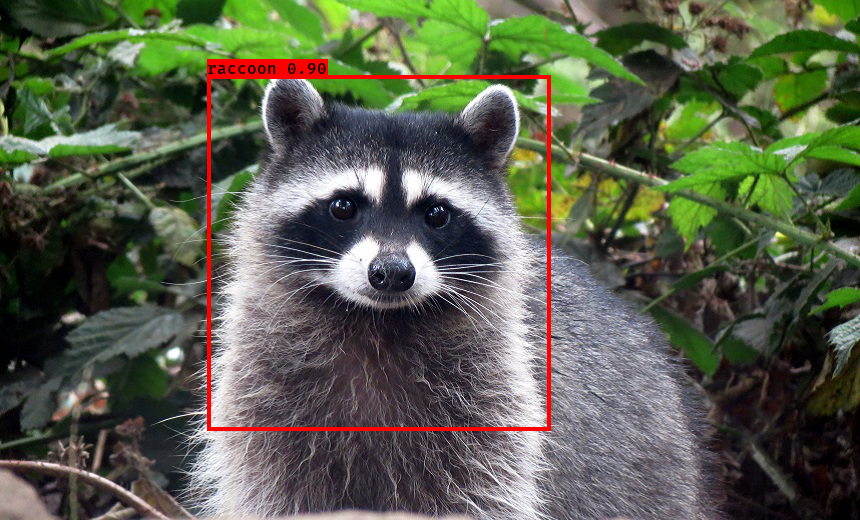

In [16]:
r_image

In [0]:
from PIL import Image
image = Image.open('kangaroo.jpg') 

In [18]:
from yolo import YOLO
yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)
r_image = yolo_model.detect_image(image)

logs/000/trained_weights_final.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.77 (151, 66) (1071, 692)
2.569371693999983


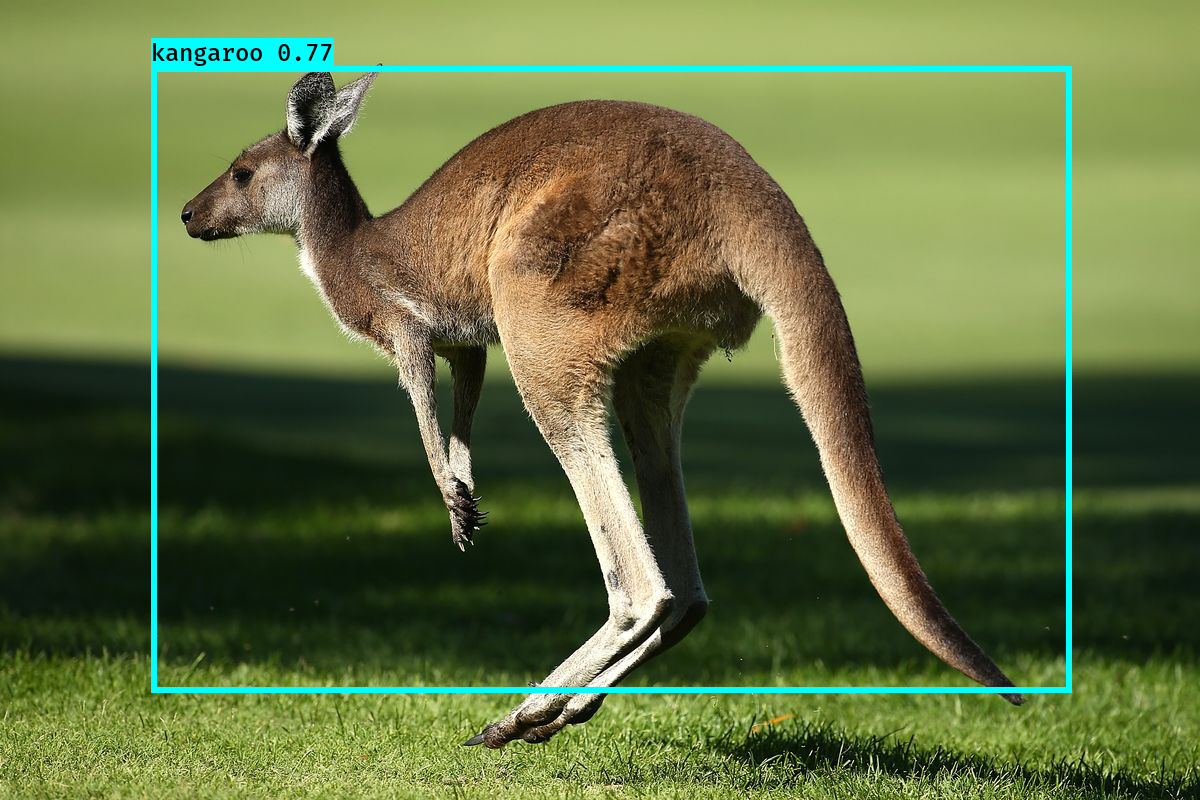

In [19]:
r_image

In [20]:
with open("2007_train.txt", "r") as f:
  d = f.readlines()
d

['VOCdevkit/JPEGImages/raccoon-3.jpg 64,11,676,479,1\n',
 'VOCdevkit/JPEGImages/raccoon-115.jpg 158,268,320,422,1\n',
 'VOCdevkit/JPEGImages/kangaroo_00128.jpg 242,181,468,403,0\n',
 'VOCdevkit/JPEGImages/kangaroo_00114.jpg 1,35,301,250,0 228,153,421,235,0\n',
 'VOCdevkit/JPEGImages/kangaroo_00100.jpg 168,97,694,371,0\n',
 'VOCdevkit/JPEGImages/kangaroo_00115.jpg 636,272,873,492,0 329,332,709,598,0 150,279,465,634,0 227,276,315,615,0\n',
 'VOCdevkit/JPEGImages/raccoon-114.jpg 277,117,356,203,1\n',
 'VOCdevkit/JPEGImages/kangaroo_00117.jpg 385,70,603,556,0\n',
 'VOCdevkit/JPEGImages/kangaroo_00116.jpg 207,78,452,516,0 432,31,808,561,0\n',
 'VOCdevkit/JPEGImages/raccoon-20.jpg 96,188,493,473,1\n',
 'VOCdevkit/JPEGImages/raccoon-34.jpg 26,8,220,184,1\n',
 'VOCdevkit/JPEGImages/kangaroo_00076.jpg 147,42,213,180,0 163,191,198,225,0 247,106,309,253,0 295,90,343,195,0\n',
 'VOCdevkit/JPEGImages/raccoon-103.jpg 137,216,330,416,1\n',
 'VOCdevkit/JPEGImages/raccoon-5.jpg 35,4,257,183,1\n',
 'VOC